# Diagnostics

A notebook to demonstrate the usage of existing diagnostics in ValEnsPy

In [1]:
import valenspy as vp
from dask.diagnostics import ProgressBar

## Loading data
Lets first load some data to apply diagnostics on. We will use the input_manager to load the data and will be working on the hortense machine.

In [2]:
manager = vp.InputManager(machine='hortense')

Lets take ERA5 data.

In [3]:
ds = manager.load_data("ERA5",["pr"], period=[2000,2001],freq="hourly",region="europe")
ds

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-2001.nc
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-2000.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['pr']


<xarray.Dataset> Size: 7GB
Dimensions:  (time: 17544, lat: 163, lon: 289)
Coordinates:
  * lon      (lon) float32 1kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * lat      (lat) float32 652B 73.5 73.25 73.0 72.75 ... 33.75 33.5 33.25 33.0
  * time     (time) datetime64[ns] 140kB 2000-01-01 ... 2001-12-31T23:00:00
Data variables:
    pr       (time, lat, lon) float64 7GB dask.array<chunksize=(3079, 55, 99), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-11 20:52:13 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    dataset:      ERA5
    period:       [2000, 2001]
    freq:         hourly
    region:       europe

## Looking at the diagnostics
Now lets look at the diagnostics available in the diagnostics module of ValEnsPy. We will look at the DailyCycle diagnostic.

In [4]:
from valenspy.diagnostic import vp_DailyCycle
print(vp_DailyCycle.description)

Daily Cycle (Model2Self)
The daily cycle of the data.
 Diagnostic function: daily_cycle
 Calculate the daily cycle of the data. If lat and lon are present, the daily cycle is averaged over the spatial dimensions lat and lon.

    Parameters
    ----------
    data : DataTree
        The data to calculate the daily cycle of.

    Returns
    -------
    Dataset
        The daily cycle of the data.
    
 Visualization function: plot_daily_cycle
 Plot the daily cycle of the data.


## Apply the diagnostic and visualizing the results
Finally we can actually apply the diagnostic and visualize the results.

In [5]:
daily_cycle_ds = vp_DailyCycle.apply(ds).compute() #As this is a dask array, nothing is computed until we call the compute method
daily_cycle_ds

<xarray.Dataset> Size: 384B
Dimensions:  (hour: 24)
Coordinates:
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    pr       (hour) float64 192B 2.508e-05 2.549e-05 ... 2.454e-05 2.476e-05
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-11 20:52:13 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    dataset:      ERA5
    period:       [2000, 2001]
    freq:         hourly
    region:       europe

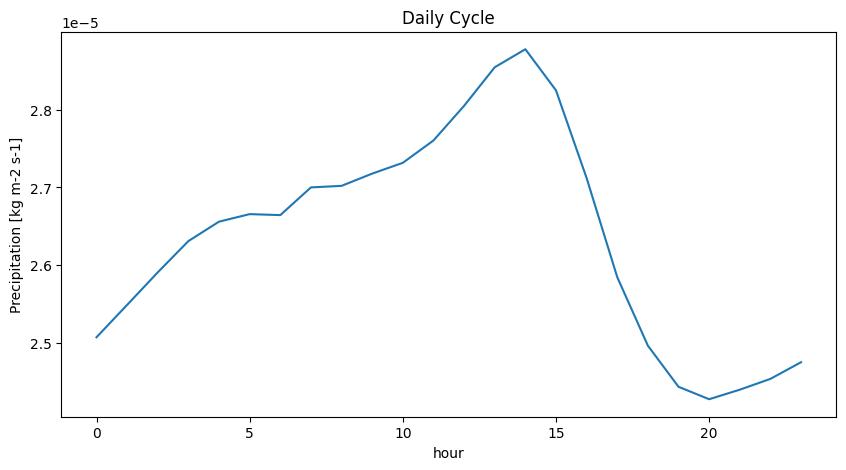

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,5))
vp_DailyCycle.visualize(daily_cycle_ds.pr)
plt.show()

## Other Diagnostic Examples
Some other examples organized by type of diagnostic.

### Model2Self
Diagnostic that looks at the model data as is.

In [7]:
from valenspy.diagnostic import vp_TimeSeriesSpatialMean

#Select a month of data to demonstrate the time series
ds_slice = ds.sel(time=slice("2000-01-01","2000-01-31"))

with ProgressBar():
    TimeSeries_ds = vp_TimeSeriesSpatialMean.apply(ds_slice).compute()

[########################################] | 100% Completed | 3.53 ss


<Axes: title={'center': 'Time Series'}, xlabel='time', ylabel='Precipitation [kg m-2 s-1]'>

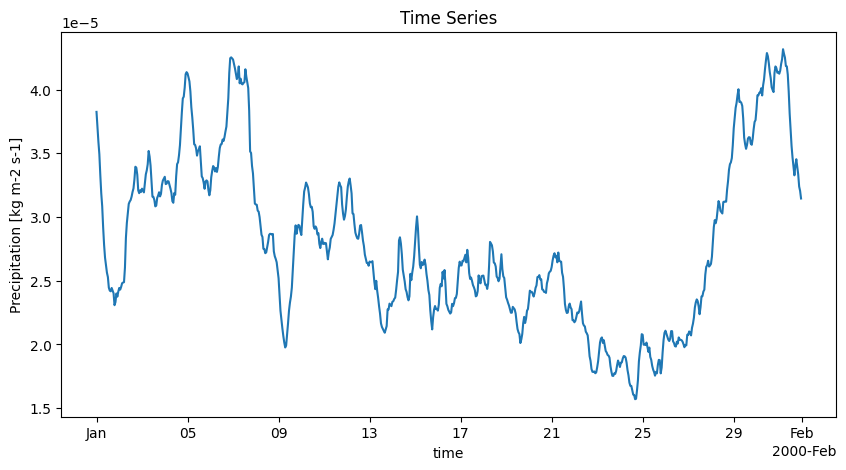

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
vp_TimeSeriesSpatialMean.visualize(TimeSeries_ds.pr)



### Model2Ref
Spatial bias

In [9]:
import matplotlib.pyplot as plt
from valenspy.diagnostic import vp_SpatialBias

ds_test = ds.isel(time=slice(0,24))
with ProgressBar():
    import numpy as np
    ds_ref = ds_test + np.random.rand(*ds_test.pr.shape) #Add random noise to the data to test the diagnostic
    SpatialBias_ds = vp_SpatialBias.apply(ds_test, ds_ref).compute()


[                                        ] | 0% Completed | 312.89 us

[########################################] | 100% Completed | 2.67 sms


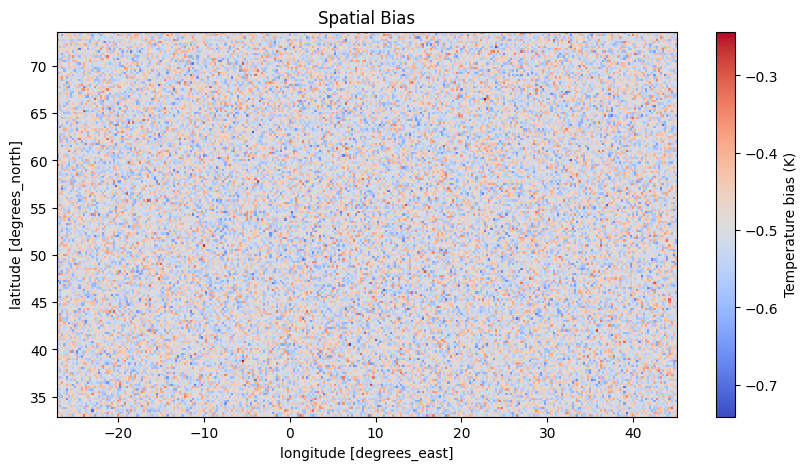

In [10]:

fig, ax = plt.subplots(1,1,figsize=(10,5))
vp_SpatialBias.visualize(SpatialBias_ds.pr)
plt.show()